In [1]:
import numpy as np 
import pandas as pd 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2
!pip install --upgrade ctgan
!pip install xgboost

/kaggle/input/Indian Liver Patient Dataset (ILPD).csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

### **Project Overview**

This notebook is an extension of Replication of Liver Disease Classification - KNN, where I replicated key parts of the paper - “Tabular Data Generation to Improve Classification of Liver Disease Diagnosis” by _Mohammad Alauthman et al._ - but used just KNN. 

Here I would be doing carrrying out the previous objectves while using XGBoost Classification

### **Replication Objective**

In this notebook, I will:

1.  Apply XGBoost Classification on the ILPD dataset.
2.  Evaluate model performance before and after applying SMOTE to assess the impact of oversampling on classification quality.
3.  Reproduce and analyze key evaluation metrics, including Accuracy, Precision, Recall, F1-Score, and ROC-AUC, to verify or challenge the findings reported in the original study.

In [2]:
path = "/kaggle/input/Indian Liver Patient Dataset (ILPD).csv"
data=pd.read_csv(path)

cols = ['Age','Gender','TB_total_bilirubin', 'DB_Direct_Bilirubin',
       'Alkphos_Alkaline_Phosphotase', 'Sgpt_Alamine_Aminotransferase',
       'Sgot_Aspartate_Aminotransferase', 'TP_Total_Protiens', 'ALB_Albumin',
       'A/G_Ratio','Selector']
data.columns = cols
data.head()

,Age,Gender,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


In [3]:
# one hot encode categorical data
data = pd.get_dummies(data)
data.head()

,Age,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector,Gender_Female,Gender_Male
0,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,False,True
1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,False,True
2,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,False,True
3,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,False,True
4,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,False,True


In [4]:
# replace NaN values with mean
data['A/G_Ratio'] = data['A/G_Ratio'].fillna(data['A/G_Ratio'].mean())
data['A/G_Ratio'].isna().sum()

0

In [5]:
# set y
y = data.Selector

# Update the columns list post one hot encoding 
cols = data.columns.tolist()
cols.remove("Selector")

# set X
features = cols
X = data[features]

In [6]:
y = y.replace({1: 0, 2: 1})

In [7]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, make_scorer
import xgboost as xgb


mcc_scorer = make_scorer(matthews_corrcoef)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'mcc': make_scorer(matthews_corrcoef)
}



# Create and train the MLP Classifier
ilp_model = xgb.XGBClassifier(
    n_estimators=1000,        
    learning_rate=0.05,     
    max_depth=4,            
    subsample=0.9,          
    colsample_bytree=0.9,   
    eval_metric="logloss",  
    random_state=42
)


# ilp_model = SVC(kernel="rbf", C=1.0, gamma="scale")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # fit + transform

skf = StratifiedKFold(n_splits=10)
cv_results = cross_validate(ilp_model, X_scaled, y, cv=skf, scoring=scoring)

# Average scores
for metric in scoring:
    print(f"Average {metric}: {cv_results['test_' + metric].mean():.3f}")


Average accuracy: 0.692
Average recall: 0.401
Average precision: 0.468
Average f1: 0.421
Average mcc: 0.224


In [8]:
# REPORTING THE FINDINGS 
# Create a dataframe with appropriate column names
smote_results = pd.DataFrame(columns=["case", "accuracy", "recall", "precision", "f1", "mcc"])

In [9]:
# retrieve the for the initial dataset metrics and add them to the df
metric_list = ["UNBALANCED"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list
smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6925,0.4011,0.4677,0.4209,0.2235


### Augmentation with SMOTE (Synthetic Minority Oversampling Technique - SMOTE)

In [10]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", Counter(y))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

print("After SMOTE:", Counter(y_smote))

Before SMOTE: Counter({0: 415, 1: 167})
After SMOTE: Counter({0: 415, 1: 415})


In [11]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_smote, y_smote, cv=skf, scoring=scoring)

# retrieve the for the initial dataset metrics and add them to the df
metric_list = ["BAL-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list
smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6925,0.4011,0.4677,0.4209,0.2235
1,BAL-AUG,0.8024,0.8491,0.7781,0.8059,0.6188


In [12]:
# get current number of rows
current_count = Counter(y_smote)[1]
double = current_count * 2
triple = current_count * 3
quadrupule = current_count * 4

In [13]:
# DOUBLE THE DATA WITH SMOTE
# double y with index 1
smote_double = SMOTE(sampling_strategy={1: double}, random_state=42)  
X_double, y_double = smote_double.fit_resample(X_smote, y_smote)
print("Double SMOTE:", Counter(y_double))

# normalize index 1 and 2, effectively doubling the data
smote_double = SMOTE(random_state=42)
X_double, y_double = smote_double.fit_resample(X_double, y_double)
print("Double SMOTE:", Counter(y_double))

Double SMOTE: Counter({1: 830, 0: 415})
Double SMOTE: Counter({0: 830, 1: 830})


In [14]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_double, y_double, cv=skf, scoring=scoring)

# retrieve the metrics for the dataset augmented 2 fold and add them to the df
metric_list = ["DD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list
print(smote_results)

         case  accuracy  recall  precision      f1     mcc
0  UNBALANCED    0.6925  0.4011     0.4677  0.4209  0.2235
1     BAL-AUG    0.8024  0.8491     0.7781  0.8059  0.6188
2      DD-AUG    0.9066  0.9253     0.8935  0.9058  0.8194


In [15]:
# TRIPLE THE DATA WITH SMOTE

# Triple the data 
smote_triple = SMOTE(sampling_strategy={1: triple}, random_state=42)  
X_triple, y_triple = smote_triple.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively doubling the data
smote_triple = SMOTE(random_state=42)
X_triple, y_triple = smote_double.fit_resample(X_triple, y_triple)
print("Double SMOTE:", Counter(y_triple))

Double SMOTE: Counter({0: 1245, 1: 1245})


In [16]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_triple, y_triple, cv=skf, scoring=scoring, return_train_score=True)
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

# retrieve the metrics for the dataset augmented 3 fold and add them to the df
metric_list = ["TD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list

Training mcc: 1.0
Validation mcc: 0.8990224813513354


In [17]:
# QUADRUPULE THE DATA WITH SMOTE

# Quadrupul data 
smote_quad = SMOTE(sampling_strategy={1: quadrupule}, random_state=42)  
X_quad, y_quad = smote_quad.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively Quadrupling the data
smote_quad = SMOTE(random_state=42)
X_quad, y_quad = smote_quad.fit_resample(X_quad, y_quad)

# calculate with augmented data
cv_results = cross_validate(ilp_model, X_quad, y_quad, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset augmented 4x and add them to the df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

smote_results.head()

Training mcc: 1.0
Validation mcc: 0.9215317504218884


,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6925,0.4011,0.4677,0.4209,0.2235
1,BAL-AUG,0.8024,0.8491,0.7781,0.8059,0.6188
2,DD-AUG,0.9066,0.9253,0.8935,0.9058,0.8194
3,TD-AUG,0.9482,0.9581,0.9405,0.9477,0.8990
4,QD-AUG,0.9602,0.9675,0.9540,0.9601,0.9215


In [18]:
# from tabulate import tabulate
# print(tabulate(smote_results, headers="keys", tablefmt="psql"))

### Augmentation with CTGAN (Conditional Tabular Generative Adversarial Network)

In [19]:
from ctgan import CTGAN
import torch
import numpy as np
import random

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Initialize and train CTGAN
ctgan = CTGAN(epochs=400)
ctgan.fit(data)

# We already know that there is an imbalane of 248 (415-248)
synthetic_minority = ctgan.sample(248, {'Selector': 2})

# combine both the original and synthetic data sets 
balanced_data = pd.concat([data, synthetic_minority])


# generate 4x the data and select accordingly - I think its best to just generate all the data i need at once and then select them accordingly 

len_balanced = len(balanced_data)
number_to_generate = (len(balanced_data) * 4) - len_balanced
generated_difference = ctgan.sample(number_to_generate)

# combine and select 
quad_data = pd.concat([balanced_data, generated_difference])
double_data = quad_data.head(len_balanced * 2)
tripple_data = quad_data.head(len_balanced * 3)

In [20]:
# USING SMOTE AND GAN

# from ctgan import CTGAN
# import torch
# import numpy as np
# import random

# # Set seeds for reproducibility
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# discrete_columns = ['Selector', 'Gender_Female', 'Gender_Male']

# # Initialize and train CTGAN
# ctgan = CTGAN(epochs=400)
# ctgan.fit(data, discrete_columns=discrete_columns)

# # make use of the data balanced earlier with smote
# balanced_data = pd.DataFrame(X_smote, columns=X.columns)
# balanced_data['Selector'] = y_smote

# # generate 4x the data and select accordingly - I think its best to just generate all the data i need at once and then select them accordingly 

# len_balanced = len(balanced_data)
# number_to_generate = (len(balanced_data) * 4) - len_balanced
# generated_difference = ctgan.sample(number_to_generate)

# # combine and select 
# quad_data = pd.concat([balanced_data, generated_difference])
# double_data = quad_data.head(len_balanced * 2)
# tripple_data = quad_data.head(len_balanced * 3)


In [21]:
y = quad_data.Selector
print("After GAN:", Counter(y))

After GAN: Counter({1: 2781, 2: 539})


In [22]:
# BALANCED DATA 

# set y
y = balanced_data.Selector
y = y.replace({1: 0, 2: 1})

# set z 
cols = balanced_data.columns.tolist()
cols.remove("Selector")
features = cols
X = balanced_data[features]
X = scaler.fit_transform(X)  # fit + transform

# Create a dataframe with appropriate column names
gan_results = pd.DataFrame(columns=["case", "accuracy", "recall", "precision", "f1", "mcc"])

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the balanced dataset and add them to the results df
metric_list = ["BAL-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list

gan_results.head()

,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7277,0.3095,0.5103,0.3426,0.2144


In [23]:
# 2x DATA 

# set y
y = double_data.Selector
y = y.replace({1: 0, 2: 1})

# set z 
features = cols
X = double_data[features]
X = scaler.fit_transform(X)  # fit + transform

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["DD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

gan_results.head()

Training mcc: 0.9995566924559011
Validation mcc: 0.11047671556773744


,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7277,0.3095,0.5103,0.3426,0.2144
1,DD-AUG,0.7753,0.1858,0.2754,0.1962,0.1105


In [24]:
# 3x DATA 

# set y
y = tripple_data.Selector
y = y.replace({1: 0, 2: 1})

# set z 
features = cols
X = tripple_data[features]
X = scaler.fit_transform(X)  # fit + transform

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["TD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

gan_results.head()

Training mcc: 0.9924679721072355
Validation mcc: 0.07878341879626984


,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7277,0.3095,0.5103,0.3426,0.2144
1,DD-AUG,0.7753,0.1858,0.2754,0.1962,0.1105
2,TD-AUG,0.8040,0.1555,0.1775,0.1398,0.0788


In [25]:
# 4x DATA 

# set y
y = quad_data.Selector
y = y.replace({1: 0, 2: 1})

# set z 
features = cols
X = quad_data[features]
X = scaler.fit_transform(X)  # fit + transform

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

Training mcc: 0.9641882900607335
Validation mcc: 0.07179821485826364


In [26]:
from tabulate import tabulate
print(tabulate(gan_results, headers="keys", tablefmt="psql"))

+----+---------+------------+----------+-------------+--------+--------+
|    | case    |   accuracy |   recall |   precision |     f1 |    mcc |
|----+---------+------------+----------+-------------+--------+--------|
|  0 | BAL-AUG |     0.7277 |   0.3095 |      0.5103 | 0.3426 | 0.2144 |
|  1 | DD-AUG  |     0.7753 |   0.1858 |      0.2754 | 0.1962 | 0.1105 |
|  2 | TD-AUG  |     0.804  |   0.1555 |      0.1775 | 0.1398 | 0.0788 |
|  3 | QD-AUG  |     0.8123 |   0.1065 |      0.2469 | 0.1115 | 0.0718 |
+----+---------+------------+----------+-------------+--------+--------+


In [27]:
gan_results.head()

,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7277,0.3095,0.5103,0.3426,0.2144
1,DD-AUG,0.7753,0.1858,0.2754,0.1962,0.1105
2,TD-AUG,0.8040,0.1555,0.1775,0.1398,0.0788
3,QD-AUG,0.8123,0.1065,0.2469,0.1115,0.0718


In [28]:
smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6925,0.4011,0.4677,0.4209,0.2235
1,BAL-AUG,0.8024,0.8491,0.7781,0.8059,0.6188
2,DD-AUG,0.9066,0.9253,0.8935,0.9058,0.8194
3,TD-AUG,0.9482,0.9581,0.9405,0.9477,0.8990
4,QD-AUG,0.9602,0.9675,0.9540,0.9601,0.9215


In [29]:
# Save Both Files 
import pandas as pd


smote_results.to_csv("gan_results.csv", index=False) 
smote_results.to_csv("smote_results.csv", index=False) 

Confusion Matrix:
[[2640  141]
 [ 482   57]]


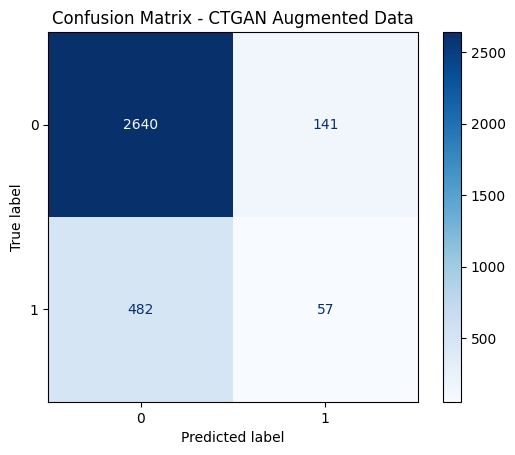

Training mcc: 0.9641882900607335
Validation mcc: 0.07179821485826364

Confusion Matrix Details:
True Negatives: 2640
False Positives: 141
False Negatives: 482
True Positives: 57
Accuracy: 0.8123


In [30]:
# Get predictions for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt  # ADD THIS IMPORT

# Get out-of-fold predictions for confusion matrix
y_pred = cross_val_predict(ilp_model, X, y, cv=skf)

# Calculate and display confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CTGAN Augmented Data')
plt.show()

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list

# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

# Additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Details:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")

Confusion Matrix for QUAD Data:
[[1582   78]
 [  54 1606]]


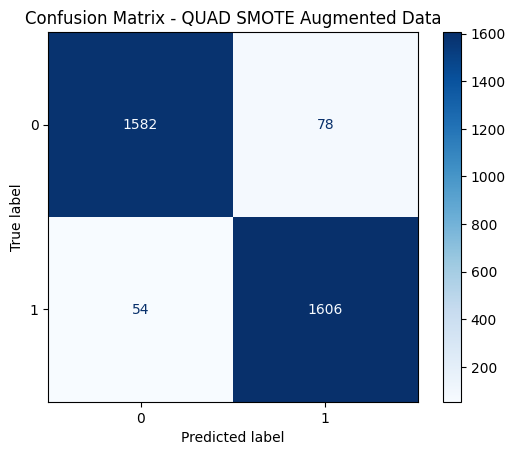


Confusion Matrix Details:
True Negatives: 1582
False Positives: 78
False Negatives: 54
True Positives: 1606
Accuracy: 0.9602
Precision: 0.9537
Recall: 0.9675

Overfitting Check:
Training mcc: 1.0
Validation mcc: 0.9215317504218884


In [31]:
# QUADRUPULE THE DATA WITH SMOTE

# Quadrupul data 
smote_quad = SMOTE(sampling_strategy={1: quadrupule}, random_state=42)  
X_quad, y_quad = smote_quad.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively Quadrupling the data
smote_quad = SMOTE(random_state=42)
X_quad, y_quad = smote_quad.fit_resample(X_quad, y_quad)

# calculate with augmented data
cv_results = cross_validate(ilp_model, X_quad, y_quad, cv=skf, scoring=scoring, return_train_score=True)

# ADD CONFUSION MATRIX HERE - USING QUAD DATA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Get out-of-fold predictions for confusion matrix - USING QUAD DATA
y_pred = cross_val_predict(ilp_model, X_quad, y_quad, cv=skf)

# Calculate and display confusion matrix - USING QUAD DATA
cm = confusion_matrix(y_quad, y_pred)
print("Confusion Matrix for QUAD Data:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - QUAD SMOTE Augmented Data')
plt.show()

# Additional metrics from confusion matrix
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Details:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print(f"Precision: {tp / (tp + fp):.4f}" if (tp + fp) > 0 else "Precision: undefined")
    print(f"Recall: {tp / (tp + fn):.4f}" if (tp + fn) > 0 else "Recall: undefined")

# retrieve the metrics for the dataset augmented 4x and add them to the df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list

# Compare traning and validation mcc to check for overfitting 
print("\nOverfitting Check:")
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

## Notes
### 22-11-25, 08:37

### FINAL RESULTS:

**ANN WITH SMOTE** 




**ANN WITH CTGAN**



### SUMMARY:
